In [8]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    confusion_matrix,
    classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

!pip install xgboost
from xgboost import XGBClassifier


In [9]:
columns = [
    "age", "sex", "cp", "trestbps", "chol",
    "fbs", "restecg", "thalach", "exang",
    "oldpeak", "slope", "ca", "thal", "target"
]


In [11]:
files = [
    "processed.cleveland.data",
    "processed.hungarian.data",
    "processed.switzerland.data",
    "processed.va.data"
]

dfs = [pd.read_csv(f, header=None, names=columns) for f in files]
df = pd.concat(dfs, ignore_index=True)

print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (920, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [12]:
# Step 1: Replace ? with NaN
df.replace("?", np.nan, inplace=True)

# Step 2: Convert all columns to numeric
for col in df.columns:
    df[col] = pd.to_numeric(df[col])

# Step 3: Fill missing values using median
df.fillna(df.median(), inplace=True)

print("After handling missing values:", df.shape)



After handling missing values: (920, 14)


In [13]:
df["target"] = df["target"].astype(int)
df["target"] = df["target"].apply(lambda x: 1 if x > 0 else 0)

df["target"].value_counts()


,count
target,
1,509
0,411


In [14]:
X = df.drop("target", axis=1)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [15]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "MCC": matthews_corrcoef(y_test, y_pred)
    }


In [16]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42
    )
}


In [17]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    results[name] = evaluate_model(model, X_test, y_test)

results_df = pd.DataFrame(results).T
results_df


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:58:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Accuracy,AUC,Precision,Recall,F1,MCC
Logistic Regression,0.826087,0.893950,0.843137,0.843137,0.843137,0.648015
Decision Tree,0.766304,0.755739,0.756522,0.852941,0.801843,0.525122
KNN,0.842391,0.867707,0.841121,0.882353,0.861244,0.680137
Naive Bayes,0.826087,0.887494,0.836538,0.852941,0.844660,0.647329
Random Forest,0.831522,0.920612,0.838095,0.862745,0.850242,0.658148
XGBoost,0.804348,0.878647,0.800000,0.862745,0.830189,0.602576



Confusion Matrix for Logistic Regression


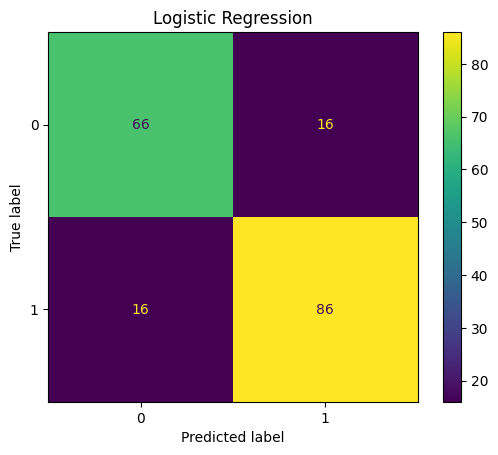


Confusion Matrix for Decision Tree


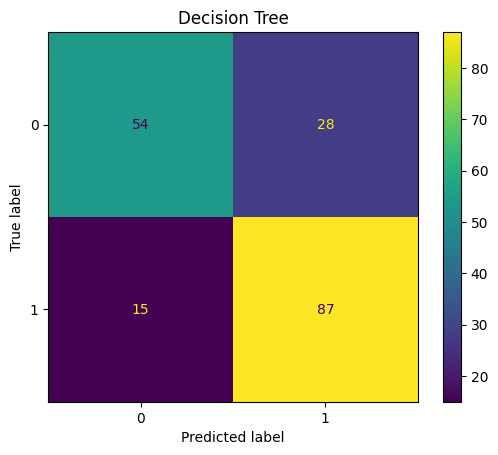


Confusion Matrix for KNN


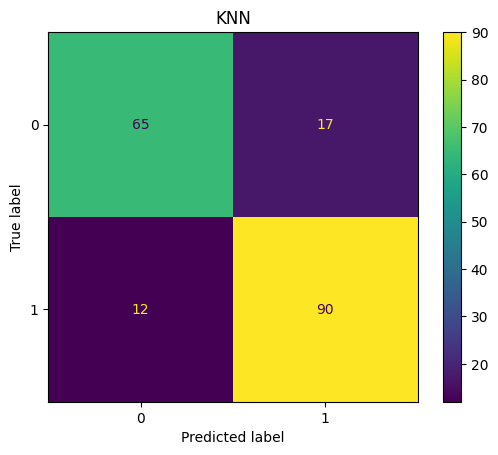


Confusion Matrix for Naive Bayes


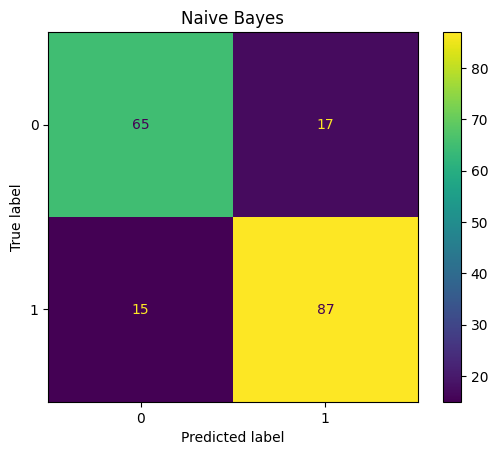


Confusion Matrix for Random Forest


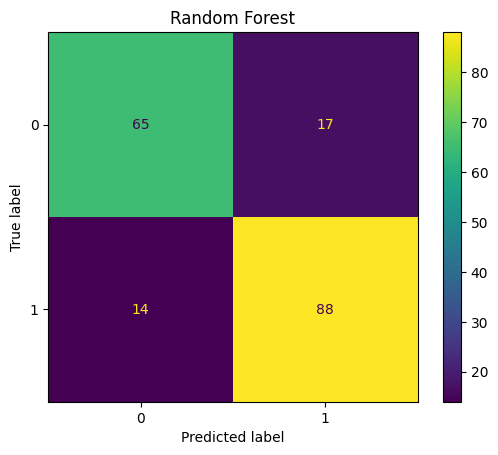


Confusion Matrix for XGBoost


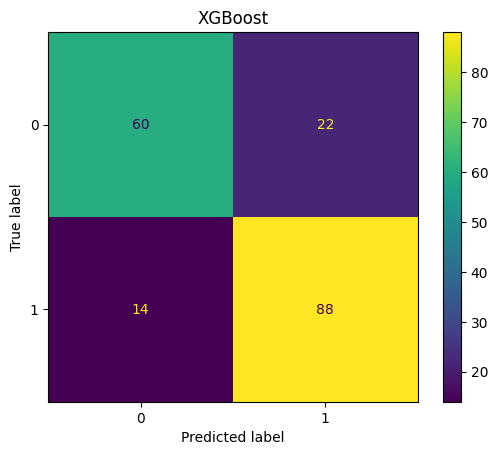

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for name, model in models.items():
    y_pred = model.predict(X_test)

    print(f"\nConfusion Matrix for {name}")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(name)
    plt.show()



In [19]:
import joblib

for name, model in models.items():
    filename = name.lower().replace(" ", "_") + ".pkl"
    joblib.dump(model, filename)

joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [20]:
!ls /content


decision_tree.pkl	 processed.cleveland.data    random_forest.pkl
knn.pkl			 processed.hungarian.data    sample_data
logistic_regression.pkl  processed.switzerland.data  scaler.pkl
naive_bayes.pkl		 processed.va.data	     xgboost.pkl


In [21]:
!ls /content/*.pkl


/content/decision_tree.pkl	  /content/random_forest.pkl
/content/knn.pkl		  /content/scaler.pkl
/content/logistic_regression.pkl  /content/xgboost.pkl
/content/naive_bayes.pkl


In [22]:
!zip models.zip *.pkl


  adding: decision_tree.pkl (deflated 79%)
  adding: knn.pkl (deflated 84%)
  adding: logistic_regression.pkl (deflated 31%)
  adding: naive_bayes.pkl (deflated 21%)
  adding: random_forest.pkl (deflated 83%)
  adding: scaler.pkl (deflated 30%)
  adding: xgboost.pkl (deflated 70%)
